#  Titanic Survival Prediction

In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Data Preparation

### Data Loading

In [2]:
# Loading the Titanic dataset
data = pd.read_csv('train.csv')

In [3]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


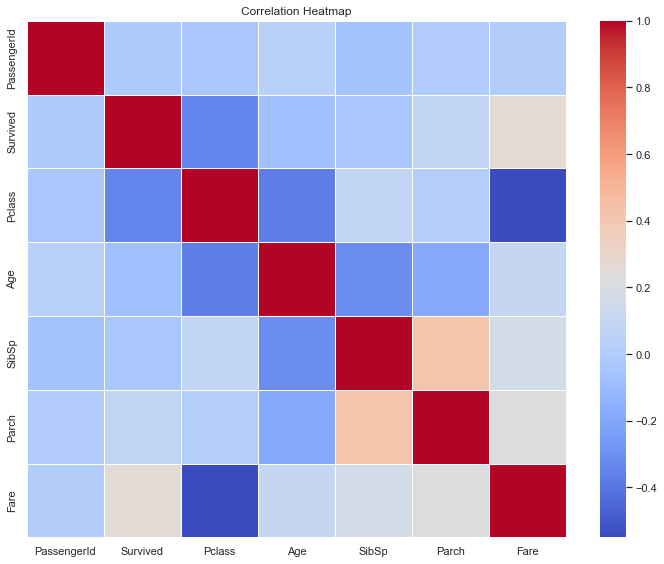

In [5]:
# Correlation matrix displaying a heatmap
corr_matrix = data.corr()
sns.set(style="white")
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

Stratified Shuffle Split for Train-Test Split

In [6]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size = 0.2, random_state = 0)

for train_index, test_index in split.split(data, data[['Survived', 'Pclass', 'Sex']]):
    strat_train_set = data.loc[train_index]
    strat_test_set = data.loc[test_index]

Data Visualization: Comparing distributions in the training and testing sets

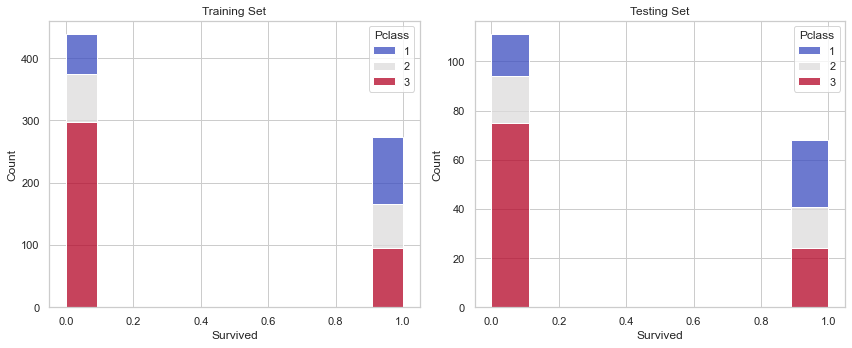

In [7]:
sns.set(style="whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(data=strat_train_set, x='Survived', hue='Pclass', multiple='stack', ax=axes[0], palette='coolwarm')
axes[0].set_title('Training Set')
axes[0].set_xlabel('Survived')
axes[0].set_ylabel('Count')

sns.histplot(data=strat_test_set, x='Survived', hue='Pclass', multiple='stack', ax=axes[1], palette='coolwarm')
axes[1].set_title('Testing Set')
axes[1].set_xlabel('Survived')
axes[1].set_ylabel('Count')

plt.tight_layout()

plt.show()

In [8]:
strat_train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 339 to 306
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Survived     712 non-null    int64  
 2   Pclass       712 non-null    int64  
 3   Name         712 non-null    object 
 4   Sex          712 non-null    object 
 5   Age          579 non-null    float64
 6   SibSp        712 non-null    int64  
 7   Parch        712 non-null    int64  
 8   Ticket       712 non-null    object 
 9   Fare         712 non-null    float64
 10  Cabin        162 non-null    object 
 11  Embarked     710 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 88.5+ KB


## Data Preprocessing

In [9]:
# Custom Transformers for Data Preprocessing
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer

### Filling missing values

In [10]:
# Imputing missing values in the 'Age' column
class AgeImputer(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        imputer = SimpleImputer(strategy='mean')
        X['Age'] = imputer.fit_transform(X[['Age']])
        return X

### Feature Encoding

In [11]:
# Encoding categorical features ('Embarked' and 'Sex') using one-hot encoding
from sklearn.preprocessing import OneHotEncoder

class FeatureCoder(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        embarked_dummies = pd.get_dummies(X['Embarked'])
        sex_dummies = pd.get_dummies(X['Sex'])
        X = pd.concat([X, embarked_dummies, sex_dummies], axis=1)
        
        return X

### Droping useless features

In [12]:
# Dropping unnecessary features
class FeatureDropper(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.drop(['Embarked', 'Name', 'Ticket', 'Cabin', 'Sex'], axis = 1)

Pipeline for Data Preprocessing

In [13]:
from sklearn.pipeline import Pipeline

data_preprocessing_pipeline = Pipeline([
    ('age_imputer', AgeImputer()),                
    ('feature_coder', FeatureCoder()),            
    ('feature_dropper', FeatureDropper()),         
])

In [14]:
# Applying data preprocessing to the training and testing sets
strat_train_set = data_preprocessing_pipeline.fit_transform(strat_train_set)
strat_test_set = data_preprocessing_pipeline.fit_transform(strat_test_set)

Scaling the features using StandardScaler

In [15]:
from sklearn.preprocessing import StandardScaler

X = strat_train_set.drop(['Survived'], axis = 1)
y = strat_train_set['Survived']

scaler = StandardScaler()
X_data_train = scaler.fit_transform(X)
y_data_train = y.to_numpy()

In [16]:
X_test = strat_test_set.drop(['Survived'], axis = 1)
y_test = strat_test_set['Survived']

scaler = StandardScaler()
X_data_test = scaler.fit_transform(X_test)
y_data_test = y_test.to_numpy()

## Model Selection and Building

In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

### GridSearchCV

Using GridSearchCV to find the best model. We will check for three, Logistic Regression, Random Forest and SVM

In [18]:
models = {
    'RandomForest': (RandomForestClassifier(), {'n_estimators': [50, 100, 200], 
                                                'max_depth': [None, 10, 20], 
                                                "min_samples_split": [2, 5, 10]}),
    
    'SVM': (SVC(), {'C': [1, 10, 100], 
                    'gamma': [0.1, 1, 
                    'scale', 'auto']}),
    
    'LogisticRegression': (LogisticRegression(), {'C': [0.001, 0.01, 0.1, 1, 10, 100]})
}

best_model = None
best_params = None
best_score = 0

for model_name, (model, param_grid) in models.items():
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', return_train_score=True)
    grid_search.fit(X_data_train, y_data_train)

    if grid_search.best_score_ > best_score:
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_
        best_score = grid_search.best_score_

best_model.fit(X_data_train, y_data_train)

y_pred = best_model.predict(X_data_test)
test_accuracy = accuracy_score(y_data_test, y_pred)

print(f"Best Model: {best_model}")
print(f"Best Parameters: {best_params}")
print(f"Best Cross-Validation Accuracy: {best_score:.4f}")
print(f"Test Set Accuracy: {test_accuracy:.4f}")

Best Model: RandomForestClassifier()
Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Best Cross-Validation Accuracy: 0.8469
Test Set Accuracy: 0.7709


From the results, it appears that the Random Forest Model is the most accurate among the tested models.

## Create prediction using best model

In [19]:
final_data = data_preprocessing_pipeline.fit_transform(data)

In [20]:
final_data

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,C,Q,S,female,male
0,1,0,3,22.000000,1,0,7.2500,0,0,1,0,1
1,2,1,1,38.000000,1,0,71.2833,1,0,0,1,0
2,3,1,3,26.000000,0,0,7.9250,0,0,1,1,0
3,4,1,1,35.000000,1,0,53.1000,0,0,1,1,0
4,5,0,3,35.000000,0,0,8.0500,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,27.000000,0,0,13.0000,0,0,1,0,1
887,888,1,1,19.000000,0,0,30.0000,0,0,1,1,0
888,889,0,3,29.699118,1,2,23.4500,0,0,1,1,0
889,890,1,1,26.000000,0,0,30.0000,1,0,0,0,1


In [21]:
X_final = final_data.drop(['Survived'], axis = 1)
y_final = final_data['Survived']

scaler = StandardScaler()
X_data_final = scaler.fit_transform(X_final)
y_data_final = y_final.to_numpy()

In [22]:
prod_clf = RandomForestClassifier()

param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 10, 15],
    "min_samples_split": [2, 5, 10]
}

grid_search = GridSearchCV(prod_clf, param_grid, cv=3, scoring = 'accuracy', return_train_score=True)
grid_search.fit(X_data_final, y_data_final)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [None, 10, 15],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             return_train_score=True, scoring='accuracy')

In [23]:
prod_final_clf = grid_search.best_estimator_

Data preprocessing for the final test set

In [24]:
test_data = pd.read_csv('test.csv')

In [25]:
final_test_data = data_preprocessing_pipeline.fit_transform(test_data)

In [26]:
X_final_test = final_test_data.fillna(method = 'ffill')

scaler = StandardScaler()
X_data_final_test = scaler.fit_transform(X_final_test)

In [27]:
predictions = prod_final_clf.predict(X_data_final_test)

In [28]:
final_df = pd.DataFrame(test_data['PassengerId'])
final_df['Survived'] = predictions
# Saving predictions to a CSV file
final_df.to_csv('predictions.csv', index=False)

In [29]:
final_df

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


The final score of prediction is 78%